In [1]:
#Leon main file 

In [2]:
#Loading all the needed Packages
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB

In [3]:
# Load all CSV files
Demand_Data_Normalized = pd.read_csv('../Data/ModelData/Demand_YearlyDemandUtilityProfile_Normalized.csv', delimiter=',')
Fuel_Cost_Data_Normalized = pd.read_csv('../Data/ModelData/FuelCost_PriceDevelopment50years.csv', delimiter=',')
Generation_Data_Normalized = pd.read_csv('../Data/ModelData/VRE_YearlyGenerationProfile_Normalized.csv', delimiter=',')
Generation_Asset_Data_Existing = pd.read_csv('../Data/ModelData/Generators_AssetData_Existing.csv', delimiter=',')
Demand_Unit_Data = pd.read_csv('../Data/ModelData/Demand_UnitSpecificData.csv', delimiter=',')
System_Demand = pd.read_csv('../Data/ModelData/System_Demand.csv', delimiter=',')
Transmission_Capacity = pd.read_csv('../Data/ModelData/Transmission Capacity.csv', delimiter=',')
Fuel_Cost_Absolute = pd.read_csv('../Data/ModelData/Fuel_Cost_Absolute.csv', delimiter=',')
Demand_Developement = pd.read_csv('../Data/ModelData/Demand_Development.csv', delimiter=',')

In [4]:
Number_of_Seasons = 5
Number_of_Years = 30
Number_of_Generators= len(Generation_Asset_Data_Existing)
Number_of_Demand_Units = len(Demand_Unit_Data)
Number_of_Price_Zones = 2
Number_of_Hours = 24

In [5]:
#Creating a function for the market clearing

def MarketClearingProblem1(Demand_Data_Normalized,
                           Fuel_Cost_Data_Normalized,
                           Generation_Data_Normalized,
                           Generation_Asset_Data_Existing,
                           Demand_Unit_Data,
                           System_Demand,
                           Transmission_Capacity,
                           Season,
                           Number_of_Price_Zones,
                           Number_of_Hours,
                           year):


    model = gp.Model("MarketClearingProblem1")

    # #Defining some iput data

    # #Define the number of generators by taking the length of the Generation_Asset_Data_Existing file
    Number_of_Generators = len(Generation_Asset_Data_Existing)
    Number_of_Demand_Units = len(Demand_Unit_Data)
    Number_of_Transmission_Lines = len(Transmission_Capacity)
    # #-----------------------------------------------------------------------------------------------------------------

    # #Data Handling to get daily demand

    # Filter Demand_Data_Normalized by the given season
    season_data = Demand_Data_Normalized[Demand_Data_Normalized['Season'] == Season]

    # Create a empty DataFrames to store the results, with 24 columns for each hour
    Daily_Demand_Normalized = pd.DataFrame(columns=[f'Hour_{i+1}' for i in range(24)])
    Daily_Demand_Utility = pd.DataFrame(columns=[f'Hour_{i+1}' for i in range(24)])

    # Loop through each row in Demand_Unit_Data
    for _, row in Demand_Unit_Data.iterrows():
        load_type = row['LoadType'].strip() # Load type (e.g., 'U_Residential', 'U_IndustryBase', 'U_IndustryPeak')
        utility_type = row['UtilityType'].strip()
        percent_load = row['% of system load'] / 100
        
        # Check if the load type exists in the Demand_Data_Normalized columns
        if load_type in season_data.columns:
            # Retrieve the hourly values for the specified load type and scale them
            hourly_values_loadtype = season_data[season_data['Hour'] <= 24][load_type].values * percent_load
            
            # Create a new row with these hourly values
            row_data = pd.DataFrame([hourly_values_loadtype], columns=[f'Hour_{i+1}' for i in range(24)])
            
            # Add identifying columns (like Load #, Zone, and LoadType) for clarity
            # row_data['Load #'] = row['Load #']
            # row_data['Zone'] = row['Zone']
            # row_data['LoadType'] = load_type
            
            # Append the new row to the result_data DataFrame
            Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
        # Check if the utility type exists in the Demand_Data_Normalized columns
        if utility_type in season_data.columns:
            # Retrieve the hourly values for the specified load type and scale them
            hourly_values_utilitytype = season_data[season_data['Hour'] <= 24][utility_type].values 
            
            # Create a new row with these hourly values
            row_data = pd.DataFrame([hourly_values_utilitytype], columns=[f'Hour_{i+1}' for i in range(24)])
            
            # Add identifying columns (like Load #, Zone, and LoadType) for clarity
            # row_data['Load #'] = row['Load #']
            # row_data['Zone'] = row['Zone']
            # row_data['LoadType'] = utility_type
            
            # Append the new row to the result_data DataFrame
            Daily_Demand_Utility = pd.concat([Daily_Demand_Utility, row_data], ignore_index=True)

    # Reset index and inspect result
    Daily_Demand_Normalized.reset_index(drop=True, inplace=True)
    Daily_Demand_Utility.reset_index(drop=True, inplace=True)


    #getting from normalized load to absolute load values
    Daily_Demand_Absolute = pd.DataFrame(
        index=range(len(Daily_Demand_Normalized)),  # Set the number of rows
        columns=[f'Hour_{i+1}' for i in range(24)]  # Set the columns for each hour
    )
    for l in range(len(Daily_Demand_Normalized)):
            for h in range(len(System_Demand)):
                Daily_Demand_Absolute.iloc[l,h] = Daily_Demand_Normalized.iloc[l,h]*System_Demand['System demand (MW)'].iloc[h]





    # #-----------------------------------------------------------------------------------------------------------------

    #Defining the decision variables

    # Defining a variable for the generators day ahead bid
    Gen_DABid = model.addVars(Number_of_Generators,Number_of_Hours, vtype=GRB.CONTINUOUS, name="Gen_DABid")
        # Defining a variable for the demand day ahead bid
    Dem_DABid = model.addVars(Number_of_Demand_Units,Number_of_Hours, vtype=GRB.CONTINUOUS, name="Dem_DABid")
    # Define voltage angle variables for each zone
    Voltage_Angle = model.addVars(Number_of_Price_Zones,Number_of_Hours, vtype=GRB.CONTINUOUS, name="Voltage_Angle")
    # Define power flow variables (as before, but now dependent on voltage angles)
    Power_Flow = model.addVars(Number_of_Transmission_Lines,Number_of_Hours, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, name="Power_Flow")

    #Define a ancilary variable for power outflow of zone
    Outflow_Zone = model.addVars(Number_of_Price_Zones,Number_of_Hours, vtype=GRB.CONTINUOUS, name="Outflow_Zone")
    Inflow_Zone = model.addVars(Number_of_Price_Zones,Number_of_Hours, vtype=GRB.CONTINUOUS, name="Inflow_Zone")

    # #-----------------------------------------------------------------------------------------------------------------

    # #Defining objective function

    #Objective function that maximizes social welfare
    objective = ( gp.quicksum(Daily_Demand_Utility.iloc[d,h] * Dem_DABid[d,h] for d in range(Number_of_Demand_Units) for h in range(Number_of_Hours)) -
                gp.quicksum(Generation_Asset_Data_Existing['C_i ($/MWh)'].iloc[g] * Gen_DABid[g,h] for g in range(Number_of_Generators) for h in range(Number_of_Hours)))
    model.setObjective(objective, GRB.MAXIMIZE)

    #-----------------------------------------------------------------------------------------------------------------

    #Defining Constraints

    #Defining maximium Production Capacity

    for p in range(Number_of_Generators):
        for h in range(Number_of_Hours):
            model.addConstr(Gen_DABid[p,h] <= Generation_Asset_Data_Existing['P_max current (MW)'].iloc[p], name=f"Production_Capacity_Constraint_{p,h}")

    #Defining maximum Demand 
    for d in range(Number_of_Demand_Units):
        for h in range(Number_of_Hours):
            model.addConstr(Dem_DABid[d,h] <= Daily_Demand_Absolute.iloc[d,h], name=f"Demand_Capacity_Constraint_{d,h}")

    #Defining the power flow

    for tr in range(Number_of_Transmission_Lines):
        for h in range(Number_of_Hours):
            from_Zone = Transmission_Capacity['FromZone'][tr]  
            to_Zone = Transmission_Capacity['ToZone'][tr]  
            reactance = Transmission_Capacity['Reactance'][tr]
            
            # Flow is proportional to the voltage angle difference divided by the reactance
            model.addConstr(
                Power_Flow[tr,h] == (Voltage_Angle[from_Zone,h] - Voltage_Angle[to_Zone,h]) / reactance,
                name=f"Flow_Equation_{from_Zone}_{to_Zone}"
            )

    # Constrain the power flow to be within the capacity of the transmission line
    for tr in range(Number_of_Transmission_Lines):
        for h in range(Number_of_Hours):
            capacity = Transmission_Capacity['Capacity [MW]'][tr]
            model.addConstr(Power_Flow[tr,h] <= capacity, name=f"Flow_Capacity_Constraint_Upper_{tr,h}")
            model.addConstr(Power_Flow[tr,h] >= -capacity, name=f"Flow_Capacity_Constraint_Lower_{tr,h}")



    # Update the power balance constraint for each node
    for zone in range(Number_of_Price_Zones):
        for h in range(Number_of_Hours):
            # Get the demand for the Zone
            demand_at_zone = gp.quicksum(
                Dem_DABid[d,h] 
                for d in range(Number_of_Demand_Units) 
                if Demand_Unit_Data['Zone'][d] == zone
            )
            
            # Get the production for this zone
            production_at_zone = gp.quicksum(
                Gen_DABid[p,h] for p in range(Number_of_Generators)
                if Generation_Asset_Data_Existing['Zone'][p] == zone
            )
            
            # Power flows into the zone (from other zones)
            Inflow_Zone = gp.quicksum(
                Power_Flow[tr,h] for tr in range(len(Transmission_Capacity))
                if Transmission_Capacity['ToZone'][tr] == zone
            )
            
            # Power flows out of the node (to other nodes)
            Outflow_Zone = gp.quicksum(
                Power_Flow[tr,h] for tr in range(len(Transmission_Capacity))
                if Transmission_Capacity['FromZone'][tr] == zone
            )
            
            # Add the power balance constraint: Production + Inflow = Demand + Outflow
            model.addConstr(demand_at_zone + Outflow_Zone == production_at_zone + Inflow_Zone, 
                            name=f"Power_Balance_Constraint_{zone,h}")
        
    model.optimize()


    # # Check optimization result
    #if model.status == GRB.INFEASIBLE:
        #print("Model is infeasible.")
    #elif model.status == GRB.UNBOUNDED:
        #print("Model is unbounded.")
    #elif model.status == GRB.TIME_LIMIT:
        #print("Time limit reached.")
    if model.status == GRB.OPTIMAL:
        #print("Optimal solution found.")
        TotalCost = model.objVal
        #print("Total Cost:",TotalCost)
        # Print the value of the Production variables
        #print("Production values:")

        # Creating an empty data frame to store the results of the model
        Daily_Results = pd.DataFrame(columns=["Year", "Season", "Hour", "Zone", "MCP"])

        # Assuming Season is defined, and Daily_Results is an empty DataFrame with the correct columns
        for h in range(Number_of_Hours):
            for zone in range(Number_of_Price_Zones):
                # Create a dictionary to store the row data for the current hour and zone
                row_data = {"Year": year, "Season": Season, "Hour": h, "Zone": zone}

                # Retrieve the dual value of the Power Balance constraint for the current zone and hour
                constr_name = f"Power_Balance_Constraint_{zone,h}"
                constr = model.getConstrByName(constr_name)

                if constr:
                    # Store the dual value (Day Ahead Price) in the row data dictionary
                    row_data["MCP"] = constr.Pi

                # Append the row data to the DataFrame as a new row
                Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)

            

            


        # # Print the value of the Voltage_Angle variables
        # print("/nVoltage Angle values:")
        # for n in range(Number_of_Nodes):
        #     print(f"Voltage_Angle[{n}] = {Voltage_Angle[n].X}")

        # Print the value of the Power_Flow variables
        # print("/nPower Flow values:")
        # for t in range(len(Transmission_Capacity)):
        #     print(f"Power_Flow[{t}] = {Power_Flow[t].X}")

    return Daily_Results









In [6]:
def LongTermMarketResults(Demand_Data_Normalized,
                           Fuel_Cost_Data_Normalized,
                           Generation_Data_Normalized,
                           Generation_Asset_Data_Existing,
                           Demand_Unit_Data,
                           System_Demand,
                           Transmission_Capacity,
                           Demand_Developement,
                           Number_of_Price_Zones,
                           Number_of_Generators,
                           Number_of_Demand_Units,
                           Number_of_Years,
                           Number_of_Seasons,
                           Number_of_Hours):
    
    Yearly_Season_Daily_Results = pd.DataFrame()
    Generation_Asset_Data_Existing_Adjusted = Generation_Asset_Data_Existing
    Demand_Data_Normalized_Adjusted = Demand_Data_Normalized

    for y in range(Number_of_Years):
        #Adjusting the cost for generation unit based on price development
        for g in range(Number_of_Generators):
            if Generation_Asset_Data_Existing_Adjusted['Technology'][g] == "Coal":
                Generation_Asset_Data_Existing_Adjusted['C_i ($/MWh)'][g] = Generation_Asset_Data_Existing_Adjusted['C_i ($/MWh)'][g] * Fuel_Cost_Data_Normalized['Coal'][y] + Generation_Asset_Data_Existing_Adjusted['Emission Facor [t/MWh]'][g] * Fuel_Cost_Data_Normalized['Co2'][g]
            if Generation_Asset_Data_Existing_Adjusted['Technology'][g] == "Gas":
                Generation_Asset_Data_Existing_Adjusted['C_i ($/MWh)'][g] = Generation_Asset_Data_Existing_Adjusted['C_i ($/MWh)'][g] * Fuel_Cost_Data_Normalized['Gas'][y] + Generation_Asset_Data_Existing_Adjusted['Emission Facor [t/MWh]'][g] * Fuel_Cost_Data_Normalized['Co2'][g]
        for d in range(Number_of_Demand_Units):
            Demand_Data_Normalized_Adjusted['D_Residential'][d] = Demand_Developement['D_Residential'][y]
            Demand_Data_Normalized_Adjusted['D_IndustryBase'][d] = Demand_Developement['D_IndustryBase'][y]
            Demand_Data_Normalized_Adjusted['D_ IndustryPeak'][d] = Demand_Developement['D_ IndustryPeak'][y]
            
                    
        for s in range(Number_of_Seasons):
            Daily_Results = MarketClearingProblem1(
                                    Demand_Data_Normalized_Adjusted,
                                Fuel_Cost_Data_Normalized,
                                Generation_Data_Normalized,
                                Generation_Asset_Data_Existing_Adjusted,
                                Demand_Unit_Data,
                                System_Demand,
                                Transmission_Capacity,
                                s,
                                Number_of_Price_Zones,
                                Number_of_Hours,
                                y)
            Yearly_Season_Daily_Results = pd.concat([Yearly_Season_Daily_Results, Daily_Results], ignore_index=True)
    return Yearly_Season_Daily_Results

In [7]:
Yearly_Season_Daily_Results = LongTermMarketResults(Demand_Data_Normalized,
                           Fuel_Cost_Data_Normalized,
                           Generation_Data_Normalized,
                           Generation_Asset_Data_Existing,
                           Demand_Unit_Data,
                           System_Demand,
                           Transmission_Capacity,
                           Demand_Developement,
                           Number_of_Price_Zones,
                           Number_of_Generators,
                           Number_of_Demand_Units,
                           Number_of_Years,
                           Number_of_Seasons,
                           Number_of_Hours)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x5b79c754
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 869 columns
Presolve time: 0.01s
Presolved: 48 rows, 115 columns, 139 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0799723e+07   1.629749e+03   0.000000e+00      0s


C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Generation_Asset_Data_Existing_Adjusted['C_i ($/MWh)'][g] = Generation_Asset_Data_Existing_Adjusted['C_i ($/MWh)'][g] * Fuel_Co

      48    2.0673732e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.03 seconds (0.00 work units)
Optimal objective  2.067373189e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x46b37caa
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 891 columns
Presolve time: 0.00s
Presolved: 48 rows, 93 columns, 117 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5222967e+07   1.136704e+03   0.000000e+00      0s
      48    1.5153098e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 s

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xcc05d914
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 870 columns
Presolve time: 0.00s
Presolved: 48 rows, 114 columns, 138 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9716643e+06   2.176472e+03   0.000000e+00      0s
      48    7.8585378e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.858537823e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x49d9fa49
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 885 columns
Presolve time: 0.01s
Presolved: 48 rows, 99 columns, 123 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7996353e+07   1.217193e+03   0.000000e+00      0s
      48    1.7906154e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.790615391e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x453c74e4
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 870 columns
Presolve time: 0.01s
Presolved: 48 rows, 114 columns, 138 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9617672e+06   2.176472e+03   0.000000e+00      0s
      48    7.8444974e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.844497368e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x76fad15f
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 885 columns
Presolve time: 0.02s
Presolved: 48 rows, 99 columns, 123 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7979117e+07   1.217193e+03   0.000000e+00      0s
      48    1.7887566e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.788756641e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x86cbe3e3
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 891 columns
Presolve time: 0.01s
Presolved: 48 rows, 93 columns, 117 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5189519e+07   1.136704e+03   0.000000e+00      0s
      48    1.5117375e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.511737547e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xb4a5ece7
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 885 columns
Presolve time: 0.02s
Presolved: 48 rows, 99 columns, 123 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7960977e+07   1.217193e+03   0.000000e+00      0s
      48    1.7867819e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.786781868e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x80ebf1e9
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 891 columns
Presolve time: 0.02s
Presolved: 48 rows, 93 columns, 117 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5171463e+07   1.136704e+03   0.000000e+00      0s
      48    1.5097879e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.509787867e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x95f35e43
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 871 columns
Presolve time: 0.00s
Presolved: 48 rows, 113 columns, 137 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0533745e+06   2.100802e+03   0.000000e+00      0s
      48    7.9308173e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.930817344e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xd3160a8d
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 868 columns
Presolve time: 0.00s
Presolved: 48 rows, 116 columns, 140 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1245382e+07   1.729817e+03   0.000000e+00      0s
      48    2.1093184e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.109318409e+07


C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xc1304836
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 891 columns
Presolve time: 0.01s
Presolved: 48 rows, 93 columns, 117 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5152399e+07   1.136704e+03   0.000000e+00      0s
      48    1.5077145e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.507714525e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x78a920c4
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 871 columns
Presolve time: 0.01s
Presolved: 48 rows, 113 columns, 137 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0422383e+06   2.100802e+03   0.000000e+00      0s
      48    7.9145356e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.914535569e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xcd417d8a
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 868 columns
Presolve time: 0.00s
Presolved: 48 rows, 116 columns, 140 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1350887e+07   1.754245e+03   0.000000e+00      0s
      48    2.1192494e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.119249430e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)



Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.505502476e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x5f68f1bc
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 870 columns
Presolve time: 0.01s
Presolved: 48 rows, 114 columns, 138 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9190872e+06   2.176472e+03   0.000000e+00      0s
      48    7.7810401e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.781040058e+06


C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xe729b5fa
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 871 columns
Presolve time: 0.00s
Presolved: 48 rows, 113 columns, 137 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0307336e+06   2.100802e+03   0.000000e+00      0s
      48    7.8973714e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.897371410e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xd10c653e
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 863 columns
Presolve time: 0.00s
Presolved: 48 rows, 121 columns, 145 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1545403e+07   2.388828e+03   0.000000e+00      0s
      48    2.1291799e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.129179889e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xc470fac3
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 873 columns
Presolve time: 0.01s
Presolved: 48 rows, 111 columns, 135 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8710303e+06   1.841609e+03   0.000000e+00      0s
      48    7.7644589e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.764458900e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x6e4dcf2a
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 887 columns
Presolve time: 0.01s
Presolved: 48 rows, 97 columns, 121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7853587e+07   1.150624e+03   0.000000e+00      0s
      48    1.7776905e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.777690477e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x41adda66
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 892 columns
Presolve time: 0.01s
Presolved: 48 rows, 92 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5078154e+07   1.096319e+03   0.000000e+00      0s
      48    1.5012429e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.501242886e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x02e14e4a
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.00s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9700021e+06   1.767315e+03   0.000000e+00      0s
      48    7.8648301e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  7.864830093e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x7dcadf79
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 863 columns
Presolve time: 0.01s
Presolved: 48 rows, 121 columns, 145 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1770366e+07   2.450177e+03   0.000000e+00      0s
      48    2.1489579e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.148957946e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xddc8f56d
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 873 columns
Presolve time: 0.00s
Presolved: 48 rows, 111 columns, 135 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8464532e+06   1.841609e+03   0.000000e+00      0s
      48    7.7326126e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.732612563e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)



CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xe35ca3ec
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.01s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9573954e+06   1.767315e+03   0.000000e+00      0s
      48    7.8488365e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.848836525e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thre

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh


CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x2242895a
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 863 columns
Presolve time: 0.00s
Presolved: 48 rows, 121 columns, 145 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1882614e+07   2.480851e+03   0.000000e+00      0s
      48    2.1586773e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.158677269e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thre

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xbfc6aedf
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 873 columns
Presolve time: 0.01s
Presolved: 48 rows, 111 columns, 135 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8340281e+06   1.841609e+03   0.000000e+00      0s
      48    7.7165528e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.716552770e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xd79b871c
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 887 columns
Presolve time: 0.00s
Presolved: 48 rows, 97 columns, 121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7786503e+07   1.150624e+03   0.000000e+00      0s
      48    1.7706850e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.770684997e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xee5339af
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 892 columns
Presolve time: 0.00s
Presolved: 48 rows, 92 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5016303e+07   1.096319e+03   0.000000e+00      0s
      48    1.4947741e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.494774074e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x43ac5c69
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.00s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9319153e+06   1.767315e+03   0.000000e+00      0s
      48    7.8165823e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  7.816582330e+06


C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xba3298c6
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 887 columns
Presolve time: 0.00s
Presolved: 48 rows, 97 columns, 121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7763282e+07   1.150624e+03   0.000000e+00      0s
      48    1.7682637e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.768263702e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Presolve removed 936 rows and 865 columns
Presolve time: 0.00s
Presolved: 48 rows, 119 columns, 143 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2080824e+07   2.388374e+03   0.000000e+00      0s
      48    2.1777130e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.177712958e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x5e609955
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 892 columns
Presolve time: 0.00s
Presolved: 48 rows, 92 columns, 116

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xab345c41
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 873 columns
Presolve time: 0.00s
Presolved: 48 rows, 111 columns, 135 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8088569e+06   1.841609e+03   0.000000e+00      0s
      48    7.6841117e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.684111694e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x4c365716
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 865 columns
Presolve time: 0.02s
Presolved: 48 rows, 119 columns, 143 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2190917e+07   2.417633e+03   0.000000e+00      0s
      48    2.1869939e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.186993931e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xdecf8dfc
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 873 columns
Presolve time: 0.00s
Presolved: 48 rows, 111 columns, 135 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7960880e+06   1.841609e+03   0.000000e+00      0s
      48    7.6677077e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.667707664e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x12603c21
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 887 columns
Presolve time: 0.00s
Presolved: 48 rows, 97 columns, 121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7715269e+07   1.150624e+03   0.000000e+00      0s
      48    1.7632640e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.763264046e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x98cb6134
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 892 columns
Presolve time: 0.01s
Presolved: 48 rows, 92 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4951034e+07   1.096319e+03   0.000000e+00      0s
      48    1.4879632e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.487963229e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x1a88f327
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.04s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8928800e+06   1.767315e+03   0.000000e+00      0s
      48    7.7673850e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.04 seconds (0.00 work units)
Optimal objective  7.767384968e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xa6b78a6d
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 865 columns
Presolve time: 0.02s
Presolved: 48 rows, 119 columns, 143 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2399046e+07   2.397100e+03   0.000000e+00      0s
      48    2.2049980e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.204997978e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xed006b7a
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 873 columns
Presolve time: 0.00s
Presolved: 48 rows, 111 columns, 135 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7701162e+06   1.841609e+03   0.000000e+00      0s
      48    7.6344653e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  7.634465256e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x658e4680
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 887 columns
Presolve time: 0.00s
Presolved: 48 rows, 97 columns, 121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7664778e+07   1.150624e+03   0.000000e+00      0s
      48    1.7580163e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.758016305e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x7b628266
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 892 columns
Presolve time: 0.00s
Presolved: 48 rows, 92 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4905043e+07   1.096319e+03   0.000000e+00      0s
      48    1.4831745e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.483174543e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x85595c7d
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.00s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8661682e+06   1.767315e+03   0.000000e+00      0s
      48    7.7338979e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.733897858e+06


C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The beha

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xadad3fcb
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 887 columns
Presolve time: 0.00s
Presolved: 48 rows, 97 columns, 121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7638432e+07   1.150624e+03   0.000000e+00      0s
      48    1.7552822e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.755282205e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xda0d152e
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 892 columns
Presolve time: 0.03s
Presolved: 48 rows, 92 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4872526e+07   1.096319e+03   0.000000e+00      0s
      48    1.4797646e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.479764554e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xc810dc2d
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.00s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8461589e+06   1.767315e+03   0.000000e+00      0s
      48    7.7085467e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  7.708546681e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)



CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xbb1308ab
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 887 columns
Presolve time: 0.00s
Presolved: 48 rows, 97 columns, 121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7602431e+07   1.150624e+03   0.000000e+00      0s
      48    1.7515175e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.751517465e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Threa

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xac9c3ef9
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 892 columns
Presolve time: 0.00s
Presolved: 48 rows, 92 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4839935e+07   1.096319e+03   0.000000e+00      0s
      48    1.4763441e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.476344057e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x590d7da6
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.02s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8259093e+06   1.767315e+03   0.000000e+00      0s
      48    7.6828487e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  7.682848653e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x347c10aa
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.00s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2702695e+07   1.879058e+03   0.000000e+00      0s
      48    2.2358126e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.235812594e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xa4b3d403
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 873 columns
Presolve time: 0.00s
Presolved: 48 rows, 111 columns, 135 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6974236e+06   1.841609e+03   0.000000e+00      0s
      48    7.5406587e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.540658710e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 887 columns
Presolve time: 0.02s
Presolved: 48 rows, 97 columns, 121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7530718e+07   1.150624e+03   0.000000e+00      0s
      48    1.7440072e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.744007225e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x502d706b
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+0

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xecf4d5a7
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 892 columns
Presolve time: 0.00s
Presolved: 48 rows, 92 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4774905e+07   1.096319e+03   0.000000e+00      0s
      48    1.4695087e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.469508736e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh


CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xaaa45961
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.01s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7847760e+06   1.767315e+03   0.000000e+00      0s
      48    7.6304898e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.630489774e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thre

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x095c3fc7
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 886 columns
Presolve time: 0.00s
Presolved: 48 rows, 98 columns, 122 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2759030e+07   1.781299e+03   0.000000e+00      0s
      48    2.2508021e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.250802148e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x8ee5ba23
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.00s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6466520e+06   1.771610e+03   0.000000e+00      0s
      48    7.4882295e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.488229545e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x63ff8524
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 887 columns
Presolve time: 0.02s
Presolved: 48 rows, 97 columns, 121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7461152e+07   1.154381e+03   0.000000e+00      0s
      48    1.7366241e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.736624119e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x7a05363f
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 892 columns
Presolve time: 0.02s
Presolved: 48 rows, 92 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4711728e+07   1.099330e+03   0.000000e+00      0s
      48    1.4627870e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.462786955e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x3b300e4c
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.02s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7443280e+06   1.773318e+03   0.000000e+00      0s
      48    7.5776715e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  7.577671529e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x09517205
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 889 columns
Presolve time: 0.02s
Presolved: 48 rows, 95 columns, 119 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2924372e+07   1.536911e+03   0.000000e+00      0s
      48    2.2663302e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.266330241e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x57eb4509
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.00s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6050205e+06   1.771610e+03   0.000000e+00      0s
      48    7.4351827e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.435182744e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x255db7f7
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 887 columns
Presolve time: 0.00s
Presolved: 48 rows, 97 columns, 121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7393286e+07   1.154381e+03   0.000000e+00      0s
      48    1.7294497e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.729449747e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x3808cf43
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 892 columns
Presolve time: 0.02s
Presolved: 48 rows, 92 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4649352e+07   1.099330e+03   0.000000e+00      0s
      48    1.4561734e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.456173366e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xbf767fed
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.00s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7024244e+06   1.773318e+03   0.000000e+00      0s
      48    7.5237973e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.523797256e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xae69c9de
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 893 columns
Presolve time: 0.02s
Presolved: 48 rows, 91 columns, 115 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2986515e+07   1.262187e+03   0.000000e+00      0s
      48    2.2825666e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.282566633e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x11e384f3
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.02s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5628792e+06   1.771610e+03   0.000000e+00      0s
      48    7.3811662e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  7.381166222e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xa0a69058
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 887 columns
Presolve time: 0.00s
Presolved: 48 rows, 97 columns, 121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7327866e+07   1.154381e+03   0.000000e+00      0s
      48    1.7225047e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.722504715e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 


CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x36e37977
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 892 columns
Presolve time: 0.00s
Presolved: 48 rows, 92 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4588341e+07   1.099330e+03   0.000000e+00      0s
      48    1.4496814e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.449681449e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Threa

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x1ee91650
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.02s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6599064e+06   1.773318e+03   0.000000e+00      0s
      48    7.4688261e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  7.468826069e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x3177ae31
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 893 columns
Presolve time: 0.00s
Presolved: 48 rows, 91 columns, 115 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3135168e+07   1.276207e+03   0.000000e+00      0s
      48    2.2963854e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.296385409e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xcae3ff6c
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.02s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5043185e+06   1.771610e+03   0.000000e+00      0s
      48    7.3056819e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  7.305681916e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x364ee98d
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 887 columns
Presolve time: 0.00s
Presolved: 48 rows, 97 columns, 121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7240822e+07   1.154381e+03   0.000000e+00      0s
      48    1.7132259e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.713225948e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x62939c7d
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 892 columns
Presolve time: 0.00s
Presolved: 48 rows, 92 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4480702e+07   1.099330e+03   0.000000e+00      0s
      48    1.4381982e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.438198190e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0xd79dba78
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 936 rows and 874 columns
Presolve time: 0.00s
Presolved: 48 rows, 110 columns, 134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5834063e+06   1.773318e+03   0.000000e+00      0s
      48    7.3695529e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.369552895e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x905cc140
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 6e+02]
Presolve removed 936 rows and 894 columns
Presolve time: 0.00s
Presolved: 48 rows, 90 columns, 114 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3249774e+07   1.135682e+03   0.000000e+00      0s
      48    2.3086117e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.308611745e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x5fa47d22
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 936 rows and 871 columns
Presolve time: 0.00s
Presolved: 48 rows, 113 columns, 137 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5192342e+06   2.106473e+03   0.000000e+00      0s
      48    7.2179727e+06   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.217972713e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x98d9d73d
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 936 rows and 885 columns
Presolve time: 0.01s
Presolved: 48 rows, 99 columns, 123 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7197730e+07   1.221701e+03   0.000000e+00      0s
      48    1.7026684e+07   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.702668429e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\1086864082.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x3a790a1a
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 6e+02]
Presolve removed 942 rows and 863 columns
Presolve time: 0.00s
Presolved: 42 rows, 121 columns, 139 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4464055e+07   1.107901e+03   0.000000e+00      0s
      42    1.4306300e+07   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.430629988e+07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 984 rows, 984 columns and 1920 nonzeros
Model fingerprint: 0x13c415d9
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 6e+02]
Presolve removed 944 rows and 842 columns
Presolve time: 0.00s
Presolved: 40 rows, 142 columns, 158 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5312811e+06   1.469015e+03   0.000000e+00      0s
      40    7.3029257e+06   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.302925715e+06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Inte

C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Results = pd.concat([Daily_Results, pd.DataFrame([row_data])], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Daily_Demand_Normalized = pd.concat([Daily_Demand_Normalized, row_data], ignore_index=True)
C:\Users\leonr\AppData\Local\Temp\ipykernel_23800\2672279125.py:221: FutureWarning: The beh

In [23]:
#Load csv files 
HourlyMCP = Yearly_Season_Daily_Results
Fuel_Cost_Forecast_Normalized = pd.read_csv('../Data/ModelData/FuelCost_PriceDevelopment50years.csv', delimiter=',')
Generation_Asset_Data_New = pd.read_csv('../Data/ModelData/Generators_AssetData_New.csv', delimiter=',')
VRE_Generation_profile = pd.read_csv('../Data/ModelData/VRE_YearlyGenerationProfile_Normalized.csv', delimiter=',')
Fuel_Cost_Absolute = pd.read_csv('../Data/ModelData/Fuel_Cost_Absolute.csv', delimiter=',')

#Define budget 
budget = 10000000000

In [24]:
#Define modelling time horizon
#Amount of years based on HourlyMCP data
Y = HourlyMCP['Year'].nunique()

#Amount of seasons in a year based on HourlyMCP data
S = HourlyMCP['Season'].nunique()

#Amount of hours in a season
H = HourlyMCP['Hour'].nunique()

#Print the amount of years, seasons and hours
print("Amount of years: ", Y)
print("Amount of seasons: ", S)
print("Amount of hours in a season: ", H)

Amount of years:  30
Amount of seasons:  5
Amount of hours in a season:  24


In [25]:
# Initialize the model
m = gp.Model("InvestmentModel")

# Define the decision variables
Inv_NewCap = m.addVars(Generation_Asset_Data_New['Unit #'], vtype=GRB.CONTINUOUS, name="Inv_NewCap")
P_NewCap = m.addVars(Generation_Asset_Data_New['Unit #'], Y, S, H, vtype=GRB.CONTINUOUS, name="P_NewCap")

# Define the objective function
profit = gp.quicksum(
    P_NewCap[i, y, s, h] * (
        HourlyMCP.loc[
            (HourlyMCP['Year'] == y) & 
            (HourlyMCP['Season'] == s) & 
            (HourlyMCP['Hour'] == h) & 
            (HourlyMCP['Zone'] == Generation_Asset_Data_New.loc[Generation_Asset_Data_New['Unit #'] == i, 'Zone'].values[0]), 
            'MCP'].values[0] - 
        Generation_Asset_Data_New.loc[Generation_Asset_Data_New['Unit #'] == i, 'C_i ($/MWh)'].values[0] *
        Fuel_Cost_Forecast_Normalized.loc[Fuel_Cost_Forecast_Normalized['Year'] == y, Generation_Asset_Data_New.loc[Generation_Asset_Data_New["Unit #"] == i, "Technology"].values[0]].values[0] - 
        Fuel_Cost_Absolute.loc[Fuel_Cost_Absolute['Cost Type'] == 'Co2', 'Cost'].values[0] *
        Fuel_Cost_Forecast_Normalized.loc[Fuel_Cost_Forecast_Normalized['Year'] == y, 'Co2'].values[0] *
        Generation_Asset_Data_New.loc[Generation_Asset_Data_New['Unit #'] == i, 'Emission Facor [t/MWh]'].values[0]
    )
    for i in Generation_Asset_Data_New['Unit #']
    for y in range(Y)
    for s in range(S)
    for h in range(H)
)

investment_cost = gp.quicksum(
    Inv_NewCap[i] * Generation_Asset_Data_New.loc[Generation_Asset_Data_New['Unit #'] == i, 'C_CapInv ($/MW)'].values[0]
    for i in Generation_Asset_Data_New['Unit #']
)

m.setObjective(73 * profit - investment_cost, GRB.MAXIMIZE)

# Define the constraints
m.addConstrs(
    (Inv_NewCap[i] <= Generation_Asset_Data_New.loc[Generation_Asset_Data_New['Unit #'] == i, 'MaxInv (MW)'].values[0] for i in Generation_Asset_Data_New['Unit #']), 
    "InvestmentMax"
)

m.addConstr(
    gp.quicksum(Inv_NewCap[i] * Generation_Asset_Data_New.loc[Generation_Asset_Data_New['Unit #'] == i, 'C_CapInv ($/MW)'].values[0] for i in Generation_Asset_Data_New['Unit #']) <= budget, 
    "Budget"
)

m.addConstrs(
    (P_NewCap[i, y, s, h] <= Inv_NewCap[i] for i in Generation_Asset_Data_New['Unit #'] for y in range(Y) for s in range(S) for h in range(H)), 
    "GenMax"
)

m.addConstrs(
    (P_NewCap[i, y, s, h] <= Inv_NewCap[i] * VRE_Generation_profile.loc[
        (VRE_Generation_profile['Hour'] == h) & 
        (VRE_Generation_profile['Season'] == s), 
        f'PVZ{Generation_Asset_Data_New.loc[Generation_Asset_Data_New["Unit #"] == i, "Zone"].values[0]}'
    ].values[0]
    for i in Generation_Asset_Data_New['Unit #'] if Generation_Asset_Data_New.loc[Generation_Asset_Data_New['Unit #'] == i, 'Technology'].values[0] == 'PV'
    for y in range(Y) for s in range(S) for h in range(H)), 
    "PVGenMax"
)

m.addConstrs(
    (P_NewCap[i, y, s, h] <= Inv_NewCap[i] * VRE_Generation_profile.loc[
        (VRE_Generation_profile['Hour'] == h) & 
        (VRE_Generation_profile['Season'] == s), 
        f'WindZ{Generation_Asset_Data_New.loc[Generation_Asset_Data_New["Unit #"] == i, "Zone"].values[0]}'
    ].values[0]
    for i in Generation_Asset_Data_New['Unit #'] if Generation_Asset_Data_New.loc[Generation_Asset_Data_New['Unit #'] == i, 'Technology'].values[0] == 'Wind'
    for y in range(Y) for s in range(S) for h in range(H)), 
    "WindGenMax"
)

# Solve the model
m.optimize()

# Check if the model found an optimal solution
if m.status == GRB.OPTIMAL:
    # Print the optimal solution
    for v in m.getVars():
        print('%s %g' % (v.varName, v.x))
    print('Obj:', m.objVal)
else:
    print("No optimal solution found. Status code:", m.status)

# Save the optimal solution to a DataFrame
df1 = pd.DataFrame({
    'Unit #': Generation_Asset_Data_New['Unit #'],
    'Investment': [Inv_NewCap[i].x for i in Generation_Asset_Data_New['Unit #']]
})

df2 = pd.DataFrame({
    'Unit #': [i for i in Generation_Asset_Data_New['Unit #'] for y in range(Y) for s in range(S) for h in range(H)],
    'Year': [y for i in Generation_Asset_Data_New['Unit #'] for y in range(Y) for s in range(S) for h in range(H)],
    'Season': [s for i in Generation_Asset_Data_New['Unit #'] for y in range(Y) for s in range(S) for h in range(H)],
    'Hour': [h for i in Generation_Asset_Data_New['Unit #'] for y in range(Y) for s in range(S) for h in range(H)],
    'Generation': [P_NewCap[i, y, s, h].x for i in Generation_Asset_Data_New['Unit #'] for y in range(Y) for s in range(S) for h in range(H)]
})

print(df1)
print(df2)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 82817 rows, 57616 columns and 162092 nonzeros
Model fingerprint: 0x3e23e98f
Coefficient statistics:
  Matrix range     [4e-04, 2e+06]
  Objective range  [1e+00, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 47177 rows and 39789 columns
Presolve time: 0.07s
Presolved: 35640 rows, 17827 columns, 71280 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 1.707e+04
 Factor NZ  : 2.845e+04 (roughly 7 MB of memory)
 Factor Ops : 7.396e+04 (less than 1 second per it

In [26]:
#print the optimal value of the objective function
print("Objective function value: ", m.objVal)

#print the dual value of the budget constraint
print("Dual value of the budget constraint: ", m.getConstrByName("Budget").Pi)

Objective function value:  1314986546.2228656
Dual value of the budget constraint:  0.0


Note: you may need to restart the kernel to use updated packages.


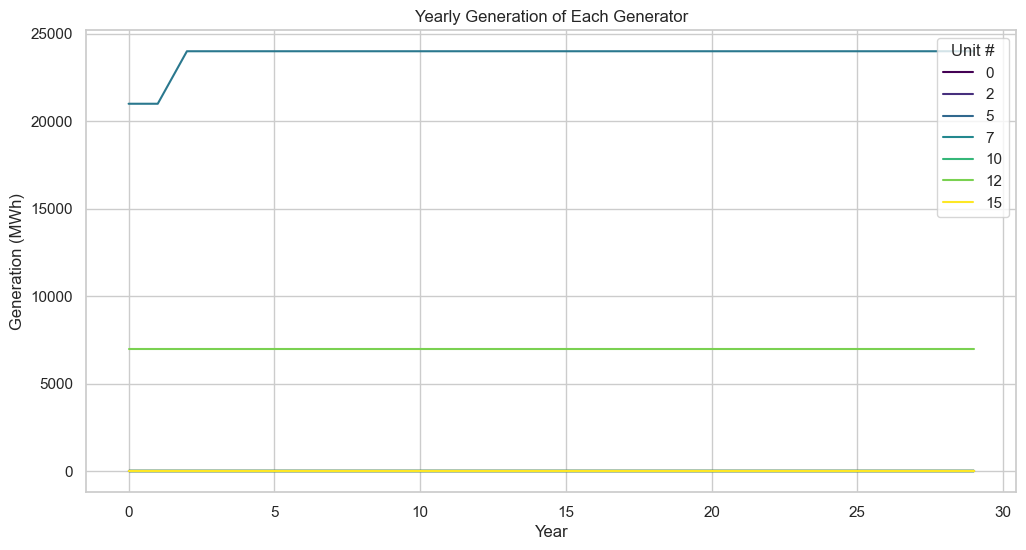

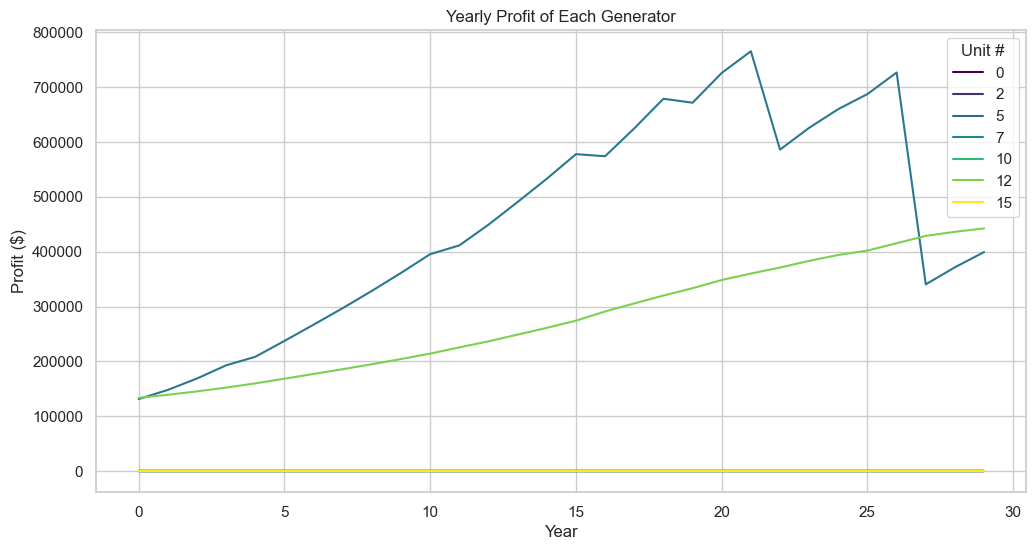

In [29]:
#Plot the yearly generation of each generator in new capacity 
%pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Create a new DataFrame to store the results
df2['Generation'] = df2['Generation'].astype(float)
df2['Year'] = df2['Year'].astype(int)
df2['Season'] = df2['Season'].astype(int)
df2['Hour'] = df2['Hour'].astype(int)

# Group the data by year and generator
df2_grouped = df2.groupby(['Year', 'Unit #'])['Generation'].sum().reset_index()

# Plot the generation for each generator
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df2_grouped, x='Year', y='Generation', hue='Unit #', palette='viridis')
plt.title('Yearly Generation of Each Generator')
plt.xlabel('Year')
plt.ylabel('Generation (MWh)')
plt.show()

#Plot the yearly profit of the investment
# Create a new DataFrame to store the results

# Calculate the profit for each row
profits = []
for idx, row in df2.iterrows():
    year = row['Year']
    season = row['Season']
    hour = row['Hour']
    unit = row['Unit #']
    generation = row['Generation']
    
    mcp = HourlyMCP.loc[
        (HourlyMCP['Year'] == year) & 
        (HourlyMCP['Season'] == season) & 
        (HourlyMCP['Hour'] == hour) & 
        (HourlyMCP['Zone'] == Generation_Asset_Data_New.loc[Generation_Asset_Data_New['Unit #'] == unit, 'Zone'].values[0]), 
        'MCP'].values[0]
    
    cost = Generation_Asset_Data_New.loc[Generation_Asset_Data_New['Unit #'] == unit, 'C_i ($/MWh)'].values[0] * \
           Fuel_Cost_Forecast_Normalized.loc[Fuel_Cost_Forecast_Normalized['Year'] == year, Generation_Asset_Data_New.loc[Generation_Asset_Data_New["Unit #"] == unit, "Technology"].values[0]].values[0] + \
           Fuel_Cost_Absolute.loc[Fuel_Cost_Absolute['Cost Type'] == 'Co2', 'Cost'].values[0] * \
           Fuel_Cost_Forecast_Normalized.loc[Fuel_Cost_Forecast_Normalized['Year'] == year, 'Co2'].values[0] * \
           Generation_Asset_Data_New.loc[Generation_Asset_Data_New['Unit #'] == unit, 'Emission Facor [t/MWh]'].values[0]
    
    profit = generation * (mcp - cost)
    profits.append(profit)

df2['Profit'] = profits

df2_grouped_profit = df2.groupby(['Year', 'Unit #'])['Profit'].sum().reset_index()

# Plot the profit for each generator
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df2_grouped_profit, x='Year', y='Profit', hue='Unit #', palette='viridis')
plt.title('Yearly Profit of Each Generator')
plt.xlabel('Year')
plt.ylabel('Profit ($)')
plt.show()
